## K-Means Clustering

The steps are broadly:
1. Data Understanding
2. EDA
3. Data Preparation for Clustering
4. Clustering
5. Final analysis and recommendation

# 1. Data Understanding

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import datetime as dt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

import warnings
warnings.filterwarnings('ignore')

In [2]:
# read the dataset
Country_df = pd.read_csv("Country-data.csv", sep=",", encoding="ISO-8859-1", header=0)
Country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [3]:
# basics of the df
Country_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
country       167 non-null object
child_mort    167 non-null float64
exports       167 non-null float64
health        167 non-null float64
imports       167 non-null float64
income        167 non-null int64
inflation     167 non-null float64
life_expec    167 non-null float64
total_fer     167 non-null float64
gdpp          167 non-null int64
dtypes: float64(7), int64(2), object(1)
memory usage: 13.1+ KB


In [4]:
# missing values
round(100*(Country_df.isnull().sum())/len(Country_df), 2)

country       0.0
child_mort    0.0
exports       0.0
health        0.0
imports       0.0
income        0.0
inflation     0.0
life_expec    0.0
total_fer     0.0
gdpp          0.0
dtype: float64

In [5]:
# convert export,import,health to actual value
Country_df['imports']=(Country_df['imports']/100)*Country_df['gdpp']
Country_df['exports']=(Country_df['exports']/100)*Country_df['gdpp']
Country_df['health']=(Country_df['health']/100)*Country_df['gdpp']
Country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


# 2. EDA

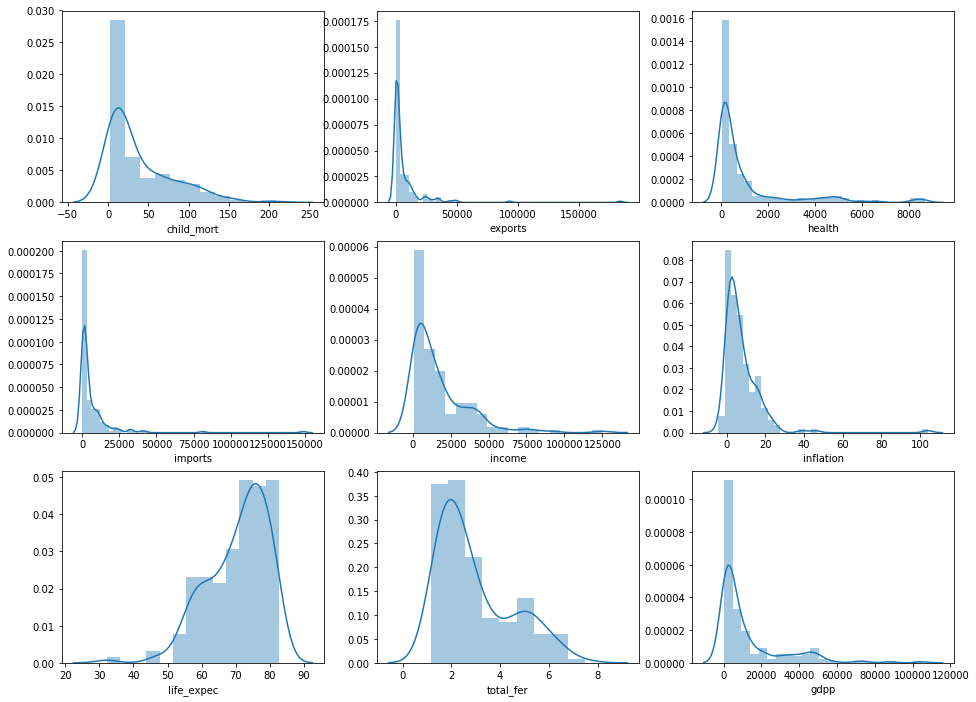

In [6]:
# Distribution plot for numerical data
feature=Country_df.iloc[:,1:]
plt.figure(figsize=(16,12))
for i in enumerate(feature):
    plt.subplot(3,3,i[0]+1)
    sns.distplot(Country_df[i[1]])

Above plot shows the distribution of numerical data.Most of the data numerical data lies above 0 and most of the data lies around 0.Most of the income data lies between 0 & 25000 and inflation lies between 0 to 20.

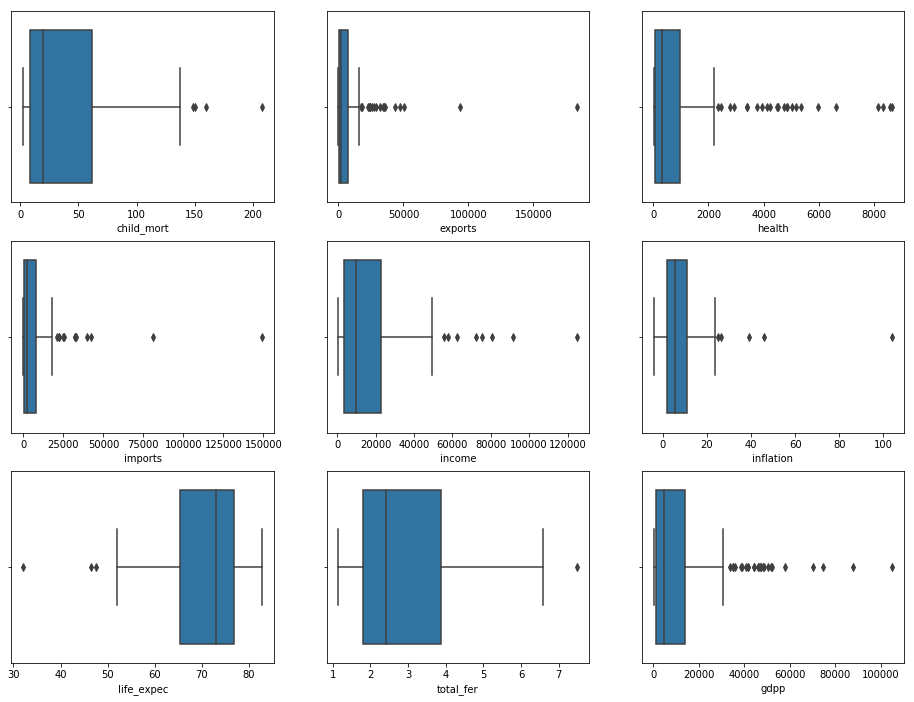

In [7]:
# Box plot for numerical data
plt.figure(figsize=(16,12))
for i in enumerate(feature):
    plt.subplot(3,3,i[0]+1)
    sns.boxplot(Country_df[i[1]])

Above plot shows the boxplot of numerical data.Health,gdpp & exports have the most outliers.

# 3. Data Preparation for Clustering

In [8]:
feature.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


### 3.a Outlier Treatment

In [9]:
# Outlier Treatment
Q4 = Country_df.exports.quantile(0.99)
Country_df['exports'][(Country_df.exports >= Q4)]=Q4

# # outlier treatment for health
Q4 = Country_df.health.quantile(0.99)
Country_df['health'][(Country_df.health >= Q4)]=Q4

# # outlier treatment for imports
Q4 = Country_df.imports.quantile(0.99)
Country_df['imports'][(Country_df.imports >= Q4)]=Q4

# # outlier treatment for inflation
Q4 = Country_df.inflation.quantile(0.99)
Country_df['inflation'][(Country_df.inflation >= Q4)]=Q4

# # outlier treatment for total_fer
Q4 = Country_df.total_fer.quantile(0.99)
Country_df['total_fer'][(Country_df.total_fer >= Q4)]=Q4

# # outlier treatment for gddp
Q4 = Country_df.gdpp.quantile(0.99)
Country_df['gdpp'][(Country_df.gdpp >= Q4)]=Q4

# # outlier treatment for child_mort
Q1 = Country_df.child_mort.quantile(0.01)
Country_df['child_mort'][(Country_df.child_mort <= Q1)]=Q1


### 3.b Hopkins Check

In [10]:
# Check the hopkins
#Calculating the Hopkins statistic
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [11]:
hopkins(Country_df.iloc[:,1:])

0.9526726589589936

In [12]:
Country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553.0
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090.0
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460.0
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530.0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200.0


### 3.c Rescaling

In [13]:
# 2. rescaling
rfm_df = Country_df[['child_mort', 'exports', 'health', 'imports', 'income','inflation', 'life_expec', 'total_fer', 'gdpp']]

# instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(167, 9)

In [14]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['child_mort', 'exports', 'health', 'imports', 'income','inflation', 'life_expec', 'total_fer', 'gdpp']
rfm_df_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291537,-0.569622,-0.566958,-0.598741,-0.808245,0.265002,-1.619092,1.926396,-0.702259
1,-0.538993,-0.473858,-0.440393,-0.413584,-0.375369,-0.372075,0.647866,-0.865054,-0.498726
2,-0.272870,-0.424000,-0.486271,-0.476100,-0.220844,1.122161,0.670423,-0.034983,-0.477434
3,2.007831,-0.381249,-0.534088,-0.463973,-0.585043,1.932987,-1.179234,2.153997,-0.530950
4,-0.695682,-0.086742,-0.178410,0.139728,0.101732,-0.764618,0.704258,-0.543736,-0.032042


# 4. Clustering

### 4.a K- Means Clustering

In [15]:
# k-means with some arbitrary k
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [16]:
kmeans.labels_

array([0, 2, 2, 0, 2, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 3, 2, 0, 2, 2, 2, 0,
       2, 1, 2, 0, 0, 2, 0, 1, 2, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 2, 1, 1,
       3, 2, 2, 2, 2, 0, 0, 2, 2, 1, 1, 0, 0, 2, 1, 0, 1, 2, 2, 0, 0, 2,
       0, 2, 1, 2, 2, 2, 0, 3, 1, 1, 2, 1, 2, 2, 0, 0, 1, 2, 0, 2, 2, 0,
       0, 2, 2, 3, 2, 0, 0, 2, 2, 0, 1, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2,
       3, 1, 0, 0, 3, 2, 0, 2, 2, 2, 2, 2, 1, 3, 2, 2, 0, 2, 2, 0, 2, 2,
       0, 3, 1, 1, 0, 0, 1, 1, 2, 2, 0, 2, 1, 3, 2, 0, 2, 0, 0, 2, 2, 2,
       2, 0, 2, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0])

#### Finding the Optimal Number of Clusters

#### SSD

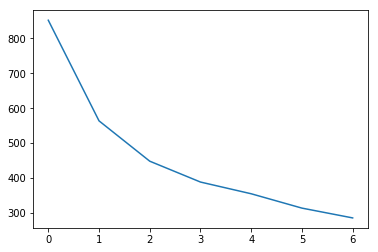

In [17]:
# elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd)

In [18]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    
    

For n_clusters=2, the silhouette score is 0.4679273614936164
For n_clusters=3, the silhouette score is 0.40287388184044215
For n_clusters=4, the silhouette score is 0.3921542163443362
For n_clusters=5, the silhouette score is 0.38454937831403146
For n_clusters=6, the silhouette score is 0.29231450652027957
For n_clusters=7, the silhouette score is 0.29922482117113863
For n_clusters=8, the silhouette score is 0.3200423301414612


In [19]:
# final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50,random_state=50)
kmeans.fit(rfm_df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=50, tol=0.0001, verbose=0)

In [20]:
kmeans.labels_

array([1, 2, 2, 1, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2, 2, 2, 1,
       2, 0, 2, 1, 1, 2, 1, 0, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 0, 2,
       0, 2, 2, 2, 2, 1, 1, 2, 2, 0, 0, 1, 1, 2, 0, 1, 2, 2, 2, 1, 1, 2,
       1, 2, 0, 2, 2, 2, 1, 0, 2, 0, 2, 0, 2, 2, 1, 1, 0, 2, 1, 2, 2, 1,
       1, 2, 2, 0, 2, 1, 1, 2, 2, 1, 0, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2,
       0, 0, 1, 1, 0, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 2, 1, 2, 2,
       1, 0, 2, 0, 1, 1, 2, 0, 2, 2, 1, 2, 0, 0, 2, 1, 2, 1, 1, 2, 2, 2,
       2, 1, 2, 0, 0, 0, 2, 2, 2, 2, 2, 1, 1])

In [21]:
# assign the label
Country_df['cluster_id'] = kmeans.labels_
Country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553.0,1
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090.0,2
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460.0,2
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530.0,1
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200.0,2


In [22]:
Country_df.cluster_id.value_counts()

2    90
1    48
0    29
Name: cluster_id, dtype: int64

#### cluster profiling

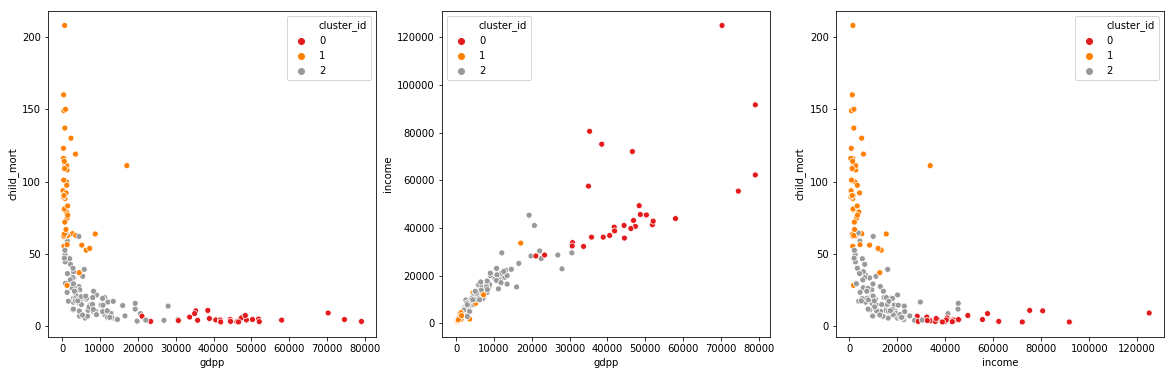

In [23]:
plt.figure(figsize=(20,6))
plt.subplot(131)
sns.scatterplot(x='gdpp',y='child_mort',hue='cluster_id',data=Country_df,palette='Set1')
plt.subplot(132)
sns.scatterplot(x='gdpp',y='income',hue='cluster_id',data=Country_df,palette='Set1')
plt.subplot(133)
sns.scatterplot(x='income',y='child_mort',hue='cluster_id',data=Country_df,palette='Set1')

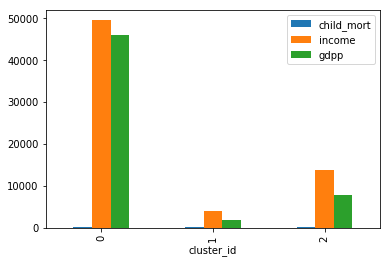

In [24]:
df=Country_df
df.drop(['country','exports', 'health', 'imports','inflation', 'life_expec', 'total_fer'], axis = 1).groupby('cluster_id').mean().plot(kind = 'bar')

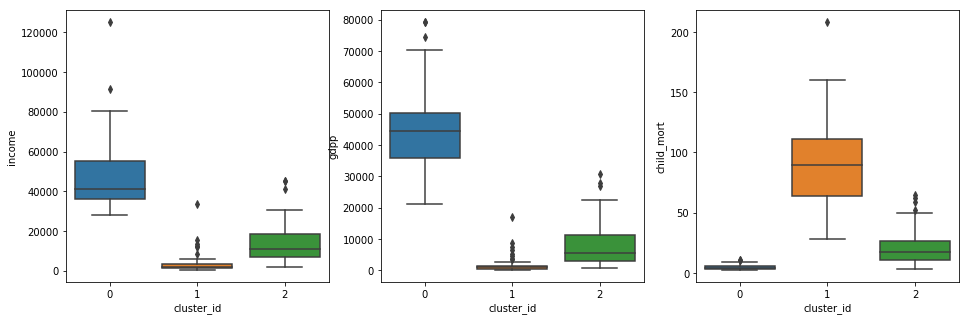

In [25]:
# plot
plt.figure(figsize=(16,5))
plt.subplot(131)
sns.boxplot(x='cluster_id', y='income', data=Country_df)
plt.subplot(132)
sns.boxplot(x='cluster_id', y='gdpp', data=Country_df)
plt.subplot(133)
sns.boxplot(x='cluster_id', y='child_mort', data=Country_df)

By above plots we can see that cluster1 is having  low income & low gdpp but high child_mort.So adding cluster id to data and sorting data with income,gdpp in ascending & gdpp in descending where cluster_id is 1,we can get top 5 countries which are in the direst need of aid.

In [26]:
Country_df[Country_df['cluster_id']==1].sort_values(by=['income','gdpp','child_mort'],ascending=[True,True,False]).head(5)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
37,"Congo, Dem. Rep.",116.0,137.2740,26.4194,165.664,609,20.80,57.5,6.5400,334.0,1
88,Liberia,89.3,62.4570,38.5860,302.802,700,5.47,60.8,5.0200,327.0,1
26,Burundi,93.6,20.6052,26.7960,90.552,764,12.30,57.7,6.2600,231.0,1
112,Niger,123.0,77.2560,17.9568,170.868,814,2.55,58.8,6.5636,348.0,1
31,Central African Republic,149.0,52.6280,17.7508,118.190,888,2.01,47.5,5.2100,446.0,1


### 4.b Hierarchical Clustering

In [27]:
rfm_df_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291537,-0.569622,-0.566958,-0.598741,-0.808245,0.265002,-1.619092,1.926396,-0.702259
1,-0.538993,-0.473858,-0.440393,-0.413584,-0.375369,-0.372075,0.647866,-0.865054,-0.498726
2,-0.272870,-0.424000,-0.486271,-0.476100,-0.220844,1.122161,0.670423,-0.034983,-0.477434
3,2.007831,-0.381249,-0.534088,-0.463973,-0.585043,1.932987,-1.179234,2.153997,-0.530950
4,-0.695682,-0.086742,-0.178410,0.139728,0.101732,-0.764618,0.704258,-0.543736,-0.032042


#### single linkage

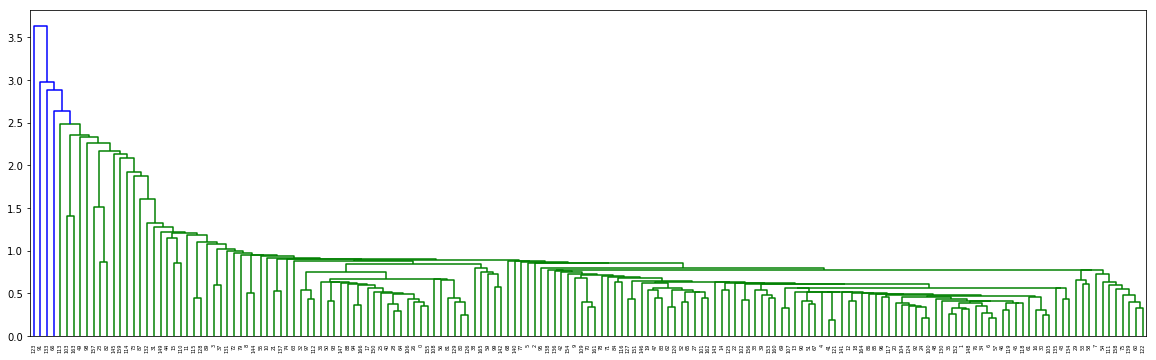

In [28]:
# single linkage
plt.figure(figsize=(20,6))
mergings = linkage(rfm_df_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

#### Complete Linkage

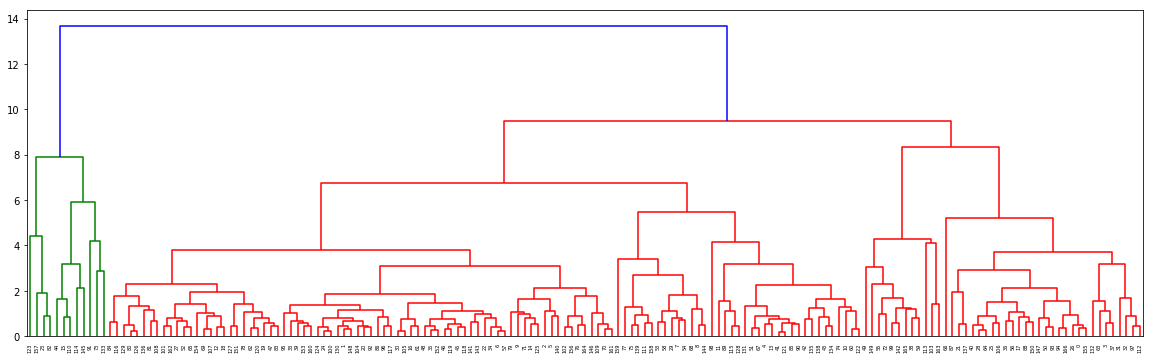

In [29]:
# complete linkage
plt.figure(figsize=(20,6))
mergings = linkage(rfm_df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [30]:
# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 0,
       1, 2, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       2, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0,
       0, 1, 1, 2, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       2, 1, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 2, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 2, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 2, 1, 1, 1, 1, 1, 0, 1, 0, 0])

In [31]:
# assign cluster labels
Country_df['cluster_labels'] = cluster_labels
Country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id,cluster_labels
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553.0,1,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090.0,2,1
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460.0,2,1
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530.0,1,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200.0,2,1


In [32]:
Country_df.cluster_labels.value_counts()

1    113
0     42
2     12
Name: cluster_labels, dtype: int64

#### cluster profiling

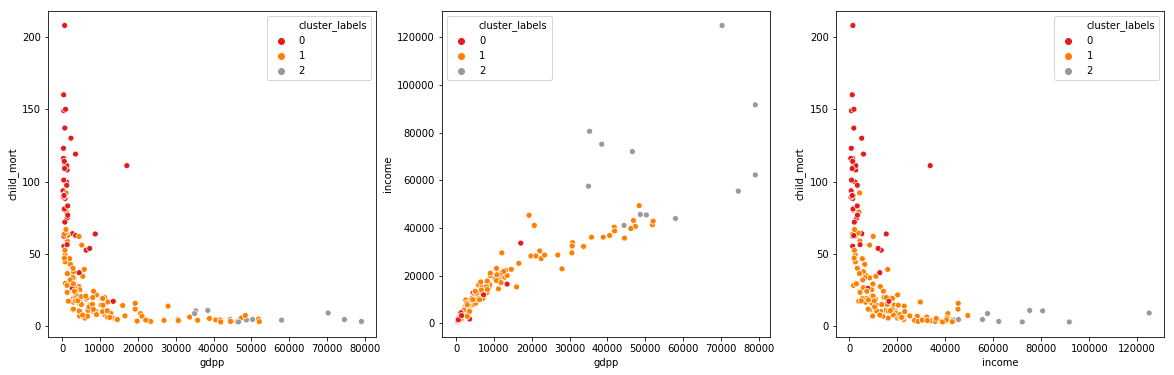

In [33]:
plt.figure(figsize=(20,6))
plt.subplot(131)
sns.scatterplot(x='gdpp',y='child_mort',hue='cluster_labels',data=Country_df,palette='Set1')
plt.subplot(132)
sns.scatterplot(x='gdpp',y='income',hue='cluster_labels',data=Country_df,palette='Set1')
plt.subplot(133)
sns.scatterplot(x='income',y='child_mort',hue='cluster_labels',data=Country_df,palette='Set1')

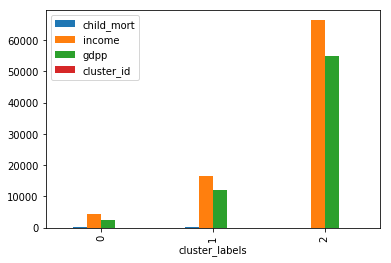

In [34]:
df=Country_df
df.drop(['country','exports', 'health', 'imports','inflation', 'life_expec', 'total_fer'], axis = 1).groupby('cluster_labels').mean().plot(kind = 'bar')

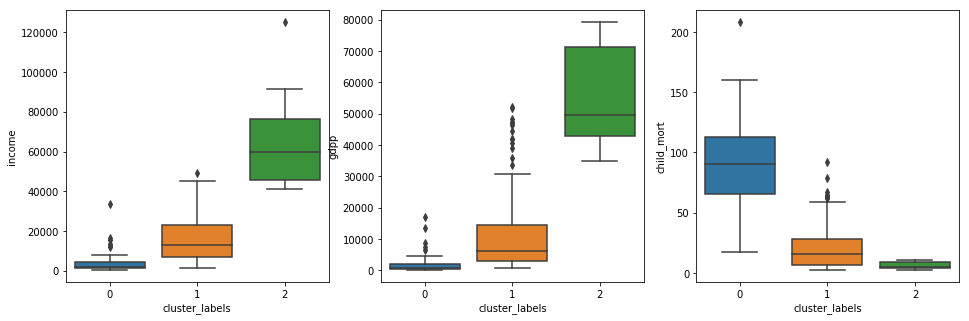

In [35]:
#plot
plt.figure(figsize=(16,5))
plt.subplot(131)
sns.boxplot(x='cluster_labels', y='income', data=Country_df)
plt.subplot(132)
sns.boxplot(x='cluster_labels', y='gdpp', data=Country_df)
plt.subplot(133)
sns.boxplot(x='cluster_labels', y='child_mort', data=Country_df)

By above plots we can see that cluster0 is having  low income & low gdpp but high child_mort.So adding cluster labels to data and sorting data with income,gdpp in ascending & gdpp in descending where cluster_labels is 1,we can get top 5 countries which are in the direst need of aid.

In [36]:
Country_df[Country_df['cluster_labels']==0].sort_values(by=['income','gdpp','child_mort'],ascending=[True,True,False]).head(5)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id,cluster_labels
37,"Congo, Dem. Rep.",116.0,137.2740,26.4194,165.664,609,20.80,57.5,6.5400,334.0,1,0
88,Liberia,89.3,62.4570,38.5860,302.802,700,5.47,60.8,5.0200,327.0,1,0
26,Burundi,93.6,20.6052,26.7960,90.552,764,12.30,57.7,6.2600,231.0,1,0
112,Niger,123.0,77.2560,17.9568,170.868,814,2.55,58.8,6.5636,348.0,1,0
31,Central African Republic,149.0,52.6280,17.7508,118.190,888,2.01,47.5,5.2100,446.0,1,0
